# Оптимизация GE

## Характеристики оборудования:

Операционная система:

In [13]:
!cat /etc/os-release

PRETTY_NAME="Ubuntu 21.10"
NAME="Ubuntu"
VERSION_ID="21.10"
VERSION="21.10 (Impish Indri)"
VERSION_CODENAME=impish
ID=ubuntu
ID_LIKE=debian
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
UBUNTU_CODENAME=impish


CPU:

In [17]:
!lscpu | grep 'Model name'
!lscpu | grep 'Socket(s)'
!lscpu | grep 'Core(s) per socket:'
!lscpu | grep 'Thread(s) per core'
!lscpu | grep 'MHz'
!lscpu | grep 'cache'

Model name:                      11th Gen Intel(R) Core(TM) i5-11300H @ 3.10GHz
Socket(s):                       1
Core(s) per socket:              4
Thread(s) per core:              2
CPU MHz:                         3100.000
CPU max MHz:                     4400,0000
CPU min MHz:                     400,0000
L1d cache:                       192 KiB
L1i cache:                       128 KiB
L2 cache:                        5 MiB
L3 cache:                        8 MiB


RAM:

In [15]:
!grep MemTotal /proc/meminfo

MemTotal:       16176172 kB


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
pd.options.display.float_format = '{:.7f}'.format
sns.set(font_scale = 1.5)
sns.set_style("whitegrid", {'axes.grid' : False})

## Анализ количества flops

$\texttt{composeG}:$ 
- mul: $678$
- add: $563$

$\texttt{composeG_raw}:$ 
- mul: $21 + n \times 64$
- add: $15 + n \times 48$

Можно также учитывать, что матрица $g g^T$ является симметрической. В этом случае:

$\texttt{composeG_raw}:$ 
- mul: $21 + n \times 58$
- add: $15 + n \times 42$

In [30]:
def ops_composeG_raw(x):
    return 36 + x * 112

def ops_composeG(x):
    return 0 * x + 1241

In [31]:
cor_num = np.arange(5, 12)

In [32]:
ops_data = {"ops_composeG_raw": ops_composeG_raw(cor_num), "ops_composeG": ops_composeG(cor_num)}

In [38]:
df = pd.DataFrame(data=ops_data, index=cor_num)

In [39]:
df

,ops_composeG_raw,ops_composeG
5,596,1241
6,708,1241
7,820,1241
8,932,1241
9,1044,1241
10,1156,1241
11,1268,1241


In [51]:
ops_composeG(8)

1241

In [50]:
ops_composeG_raw(8)

932

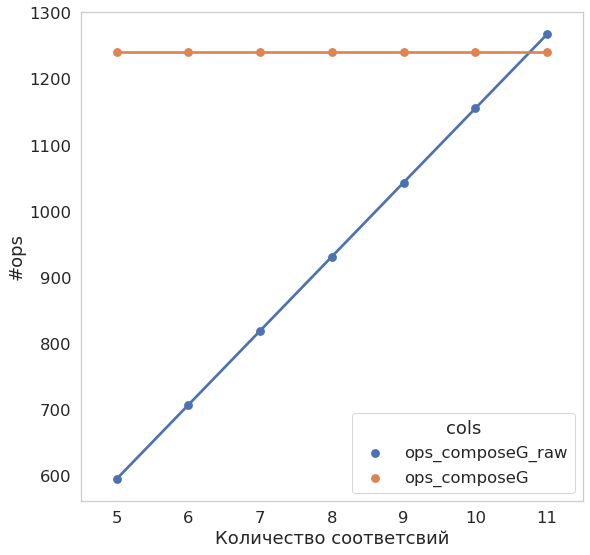

In [49]:
fig, ax = plt.subplots(figsize=(9, 9))
sns.pointplot(
    ax=ax,
    x="index", 
    y="vals", 
    hue='cols', 
    data=df.reset_index().melt(
        'index', var_name='cols',  value_name='vals'), 
    kind='point')
ax.set(ylabel=f"#ops", xlabel="Количество соответсвий");

## Сравнение реализаций GE

### Векторизованная версия

In [3]:
motion_df = pd.read_csv("./error_motion.csv")
stability_df = pd.read_csv("./error_stability.csv")

In [4]:
stability_inf_mask = stability_df["ATE"].isin([np.inf, -np.inf])
stability_99q_mask = stability_df["ATE"] < stability_df["ATE"].quantile(.99)
stability_df[~stability_inf_mask & stability_99q_mask].groupby(
    ["method_name"])[["ARE", "ATE", "RTE", "time"]].describe().T

method_name          8pt      8pt_raw
ARE  count  9893.0000000 9907.0000000
     mean      0.0352938    0.0357994
     std       0.0681595    0.0691228
     min       0.0000006    0.0000004
     25%       0.0017629    0.0017804
     50%       0.0048795    0.0051280
     75%       0.0371899    0.0376715
     max       0.6587250    0.7628190
ATE  count  9893.0000000 9907.0000000
     mean      2.6409428    2.6518421
     std       7.4620753    7.3871111
     min       0.0000079    0.0000040
     25%       0.0516239    0.0519543
     50%       0.1732640    0.1794560
     75%       1.7309000    1.8349750
     max      79.3104000   79.8292000
RTE  count  9893.0000000 9907.0000000
     mean      0.2058237    0.2057668
     std       0.4223610    0.4201445
     min       0.0000011    0.0000002
     25%       0.0049578    0.0051693
     50%       0.0164039    0.0171700
     75%       0.1230640    0.1287535
     max       1.5708000    1.5708000
time count  9893.0000000 9907.0000000
     mean      0.0000743    0.0000361
     std       0.0000206    0.0000099
     min       0.0000222    0.0000110
     25%       0.0000554    0.0000271
     50%       0.0000881    0.0000422
     75%       0.0000905    0.0000436
     max       0.0001162    0.0000491

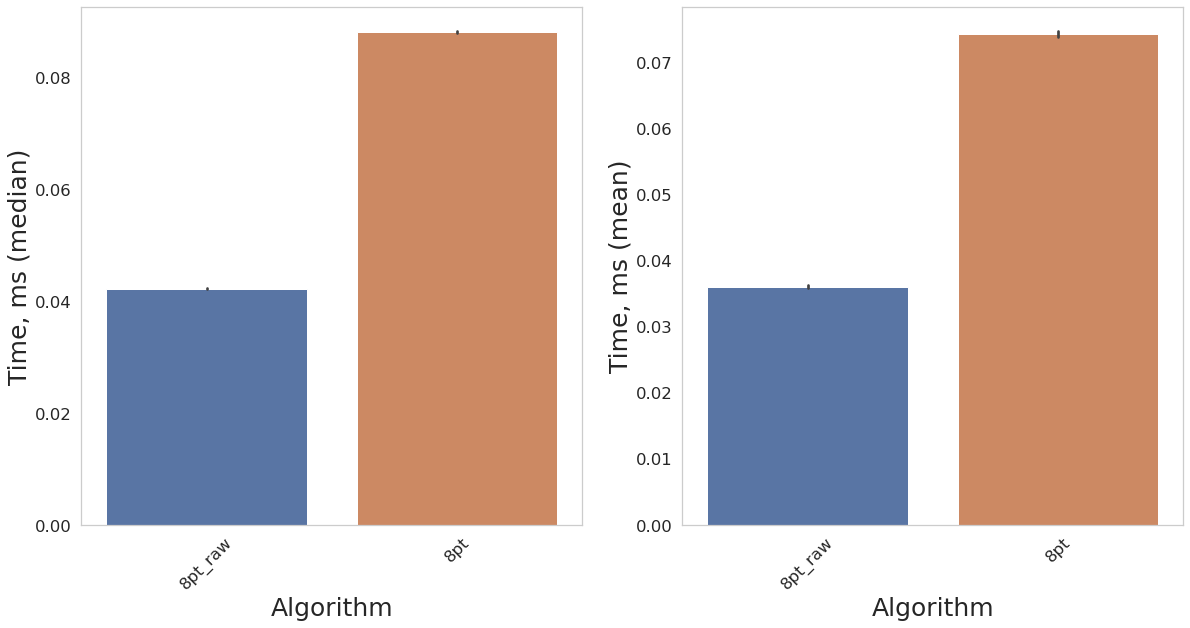

In [7]:
fig, axes = plt.subplots(ncols=2,figsize=(18, 9))
fig.subplots_adjust(left=0.05, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)

for i, (est_name, est) in enumerate(esimators.items()):
        order = stability_df.groupby(["method_name"])['time'].aggregate(est).reset_index().sort_values('time')
        sns.barplot(
            ax=axes[i], 
            x="method_name", 
            y="time", 
            data=stability_df,
            estimator=est,
            order=order['method_name']
        )
        
        axes[i].set(ylabel=f"Time, ms ({est_name})", xlabel="Algorithm")
        axes[i].yaxis.label.set_size(25)
        axes[i].xaxis.label.set_size(25)
        axes[i].tick_params(axis='x', rotation=45)

### Версия без векторизации

In [8]:
stability_inf_mask = stability_df["ATE"].isin([np.inf, -np.inf])
stability_99q_mask = stability_df["ATE"] < stability_df["ATE"].quantile(.99)
stability_df[~stability_inf_mask & stability_99q_mask].groupby(
    ["method_name"])[["ARE", "ATE", "RTE", "time"]].describe().T

method_name          8pt      8pt_raw
ARE  count  9907.0000000 9893.0000000
     mean      0.0357992    0.0352928
     std       0.0691237    0.0681601
     min       0.0000005    0.0000002
     25%       0.0017795    0.0017616
     50%       0.0051326    0.0048795
     75%       0.0376715    0.0371902
     max       0.7628200    0.6587240
ATE  count  9907.0000000 9893.0000000
     mean      2.6518316    2.6407873
     std       7.3868716    7.4621543
     min       0.0000081    0.0000054
     25%       0.0519622    0.0516315
     50%       0.1794280    0.1730430
     75%       1.8349000    1.7309900
     max      79.8289000   79.3099000
RTE  count  9907.0000000 9893.0000000
     mean      0.2057665    0.2058212
     std       0.4201448    0.4223636
     min       0.0000007    0.0000004
     25%       0.0051668    0.0049609
     50%       0.0171808    0.0164039
     75%       0.1287535    0.1230640
     max       1.5708000    1.5708000
time count  9907.0000000 9893.0000000
     mean      0.0000757    0.0000541
     std       0.0000210    0.0000154
     min       0.0000228    0.0000149
     25%       0.0000570    0.0000398
     50%       0.0000892    0.0000642
     75%       0.0000915    0.0000660
     max       0.0001460    0.0001051

In [6]:
esimators = {"median": np.median, "mean": np.mean}

In [5]:
stability_df['time'] = stability_df['time'] * 1000

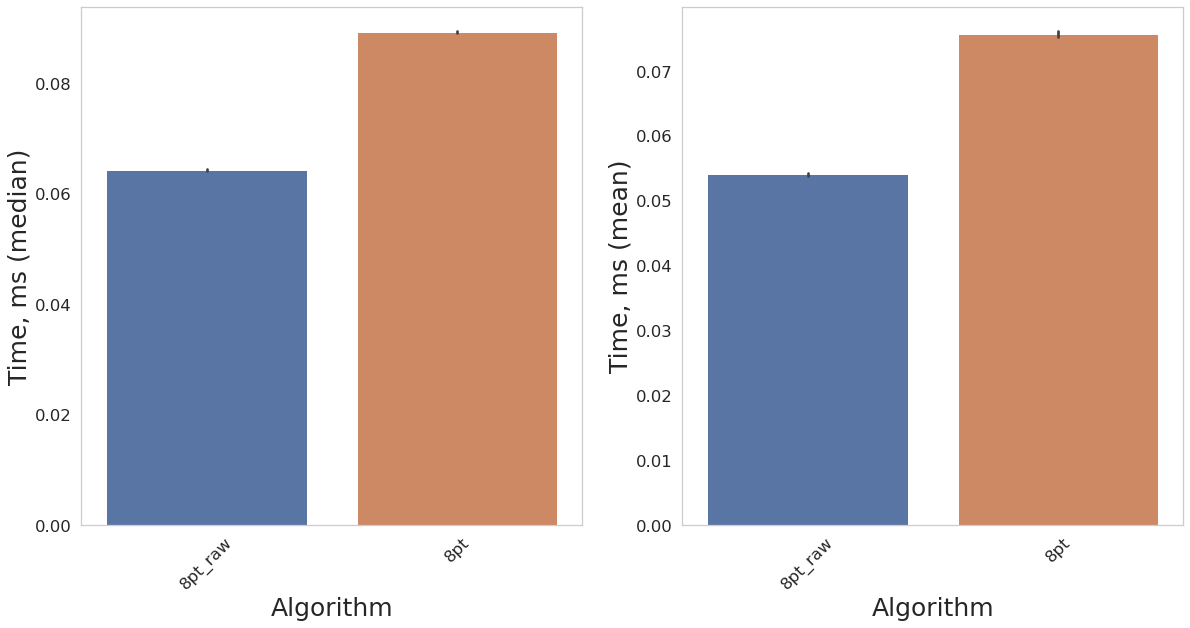

In [11]:
fig, axes = plt.subplots(ncols=2,figsize=(18, 9))
fig.subplots_adjust(left=0.05, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)

for i, (est_name, est) in enumerate(esimators.items()):
        order = stability_df.groupby(["method_name"])['time'].aggregate(est).reset_index().sort_values('time')
        sns.barplot(
            ax=axes[i], 
            x="method_name", 
            y="time", 
            data=stability_df,
            estimator=est,
            order=order['method_name']
        )
        
        axes[i].set(ylabel=f"Time, ms ({est_name})", xlabel="Algorithm")
        axes[i].yaxis.label.set_size(25)
        axes[i].xaxis.label.set_size(25)
        axes[i].tick_params(axis='x', rotation=45)